In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Install basic libraries
!pip install pandas networkx matplotlib

# Install PyTorch and PyTorch Geometric
!pip install torch torch-geometric


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.5 MB/s eta 0:00:00


Graphical Neural Network


In [ ]:
import pandas as pd

# Load the datasets
diseases_df = pd.read_csv('diseases.csv')
health_conditions_df = pd.read_csv('health_conditions.csv')
medications_df = pd.read_csv('medications.csv')
patient_medications_df = pd.read_csv('patient_medications.csv')
patients_df = pd.read_csv('patients.csv')

# Display the first few rows to confirm loading
print("Diseases Data:\n", diseases_df.head())
print("Health Conditions Data:\n", health_conditions_df.head())
print("Medications Data:\n", medications_df.head())
print("Patient Medications Data:\n", patient_medications_df.head())
print("Patients Data:\n", patients_df.head())


Diseases Data:
    DiseaseID         DiseaseName
0          1         Lung Cancer
1          2  Chronic Bronchitis
Health Conditions Data:
    HealthConditionID  ConditionName
0                  1       Diabetes
1                  2   Hypertension
2                  3         Asthma
3                  4  Heart Disease
4                  5           COPD
Medications Data:
    MedicationID MedicationName  PrescribedForDiseaseID
0             1      Cisplatin                       1
1             2    Carboplatin                       1
2             3     Paclitaxel                       2
3             4    Gemcitabine                       2
4             5      Docetaxel                       2
Patient Medications Data:
    PatientID  MedicationID
0          1             3
1          2             8
2          2             1
3          3             8
4          3             8
Patients Data:
    PatientID  Age  Smokes  Alcohol  DiseaseID  HealthConditionID
0          1   69       5

In [ ]:
import networkx as nx

# Create a new graph
ehr_graph = nx.Graph()

# Add patient nodes with real features (age, smokes, alcohol)
for _, row in patients_df.iterrows():
    ehr_graph.add_node(f'patient_{row["PatientID"]}', type='patient',
                       age=row['Age'], smokes=row['Smokes'], alcohol=row['Alcohol'])

# Add disease nodes
for _, row in diseases_df.iterrows():
    ehr_graph.add_node(f'disease_{row["DiseaseID"]}', type='disease', name=row['DiseaseName'])

# Add health condition nodes
for _, row in health_conditions_df.iterrows():
    ehr_graph.add_node(f'condition_{row["HealthConditionID"]}', type='condition', name=row['ConditionName'])

# Add medication nodes
for _, row in medications_df.iterrows():
    ehr_graph.add_node(f'medication_{row["MedicationID"]}', type='medication', name=row['MedicationName'])

# Add edges between patients and diseases
for _, row in patients_df.iterrows():
    ehr_graph.add_edge(f'patient_{row["PatientID"]}', f'disease_{row["DiseaseID"]}')

# Add edges between patients and health conditions
for _, row in patients_df.iterrows():
    ehr_graph.add_edge(f'patient_{row["PatientID"]}', f'condition_{row["HealthConditionID"]}')

# Add edges between patients and medications (from patient_medications.csv)
for _, row in patient_medications_df.iterrows():
    ehr_graph.add_edge(f'patient_{row["PatientID"]}', f'medication_{row["MedicationID"]}')

# Add edges between medications and diseases (from medications.csv)
for _, row in medications_df.iterrows():
    ehr_graph.add_edge(f'medication_{row["MedicationID"]}', f'disease_{row["PrescribedForDiseaseID"]}')


In [ ]:
import torch
from torch_geometric.data import Data

# Create node features for each node (patients get real features, others get dummy)
node_features = []
node_mapping = {}

for i, (node, data) in enumerate(ehr_graph.nodes(data=True)):
    if data['type'] == 'patient':
        features = [data['age'], data['smokes'], data['alcohol']]
        node_features.append(features)
    else:
        node_features.append([0, 0, 0])  # Dummy features for diseases, medications, conditions
    node_mapping[node] = i

# Convert node features to a tensor
node_features = torch.tensor(node_features, dtype=torch.float)

# Convert the graph's edges into PyTorch Geometric edge_index format
edges = list(ehr_graph.edges)
edge_index = torch.tensor([[node_mapping[u], node_mapping[v]] for u, v in edges], dtype=torch.long).t().contiguous()

# Create the data object for PyTorch Geometric
data = Data(x=node_features, edge_index=edge_index)


In [ ]:
import torch
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return x


In [ ]:
# Create a mapping from MedicationID to an index (for classification purposes)
medication_to_index = {med_id: idx for idx, med_id in enumerate(medications_df['MedicationID'].unique())}

# Assign labels where each patient is linked to one medication (the medication they are taking)
labels = torch.zeros(len(node_features), dtype=torch.long)  # Initialize with zeros
for _, row in patient_medications_df.iterrows():
    patient_node = node_mapping[f'patient_{row["PatientID"]}']
    medication_id = row["MedicationID"]
    labels[patient_node] = medication_to_index[medication_id]  # Use the mapped index

# Initialize the GCN model
num_medications = len(medication_to_index)  # Number of unique medications
model = GCN(in_channels=3, hidden_channels=16, out_channels=num_medications)

# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = torch.nn.CrossEntropyLoss()

# Training loop
for epoch in range(100):
    optimizer.zero_grad()  # Zero gradients
    out = model(data.x, data.edge_index)  # Forward pass
    loss = loss_fn(out, labels)  # Compute loss
    loss.backward()  # Backpropagation
    optimizer.step()  # Update parameters

    if epoch % 10 == 0:  # Print loss every 10 epochs
        print(f'Epoch {epoch}, Loss: {loss.item()}')


Epoch 0, Loss: 36.50352478027344
Epoch 10, Loss: 12.265562057495117
Epoch 20, Loss: 3.740844488143921
Epoch 30, Loss: 2.65038800239563
Epoch 40, Loss: 2.082498788833618
Epoch 50, Loss: 1.8876100778579712
Epoch 60, Loss: 1.8124903440475464
Epoch 70, Loss: 1.7607389688491821
Epoch 80, Loss: 1.7282476425170898
Epoch 90, Loss: 1.700479507446289


In [ ]:
# Get predictions for the patients
with torch.no_grad():
    predictions = model(data.x, data.edge_index)

# Get the predicted medication for each patient
predicted_medications = predictions.argmax(dim=1)  # Get the index of the highest predicted medication

# Map the predicted indices back to Medication IDs
index_to_medication = {v: k for k, v in medication_to_index.items()}

# Display recommended medications for each patient
for patient_node, pred_med_index in zip(node_mapping, predicted_medications):
    if 'patient' in patient_node:
        patient_id = patient_node.split('_')[1]
        predicted_med_id = index_to_medication[pred_med_index.item()]
        print(f"Patient {patient_id} is recommended Medication {predicted_med_id}")



Patient 1 is recommended Medication 1
Patient 2 is recommended Medication 1
Patient 3 is recommended Medication 1
Patient 4 is recommended Medication 1
Patient 5 is recommended Medication 1
Patient 6 is recommended Medication 5
Patient 7 is recommended Medication 5
Patient 8 is recommended Medication 5
Patient 9 is recommended Medication 5
Patient 10 is recommended Medication 7
Patient 11 is recommended Medication 1
Patient 12 is recommended Medication 1
Patient 13 is recommended Medication 5
Patient 14 is recommended Medication 9
Patient 15 is recommended Medication 5
Patient 16 is recommended Medication 5
Patient 17 is recommended Medication 1
Patient 18 is recommended Medication 1
Patient 19 is recommended Medication 1
Patient 20 is recommended Medication 1
Patient 21 is recommended Medication 7
Patient 22 is recommended Medication 7
Patient 23 is recommended Medication 1
Patient 24 is recommended Medication 3
Patient 25 is recommended Medication 1
Patient 26 is recommended Medicati

In [ ]:
# Training loop with accuracy calculation
for epoch in range(100):
    optimizer.zero_grad()  # Zero gradients
    out = model(data.x, data.edge_index)  # Forward pass
    loss = loss_fn(out, labels)  # Compute loss
    loss.backward()  # Backpropagation
    optimizer.step()  # Update parameters

    # Calculate accuracy
    predictions = out.argmax(dim=1)  # Get the index of the highest predicted medication
    correct = (predictions == labels).sum().item()  # Count correct predictions
    accuracy = correct / len(labels)  # Calculate accuracy as a percentage

    if epoch % 10 == 0:  # Print loss and accuracy every 10 epochs
        print(f'Epoch {epoch}, Loss: {loss.item()}, Accuracy: {accuracy:.4f}')

# Final accuracy after training
with torch.no_grad():
    predictions = model(data.x, data.edge_index)

correct = (predictions.argmax(dim=1) == labels).sum().item()  # Count correct predictions
accuracy = correct / len(labels)  # Calculate accuracy
print(f'Final Accuracy: {accuracy:.4f}')


Epoch 0, Loss: 1.675047516822815, Accuracy: 0.3731
Epoch 10, Loss: 1.6548398733139038, Accuracy: 0.3731
Epoch 20, Loss: 1.6363182067871094, Accuracy: 0.3731
Epoch 30, Loss: 1.618586778640747, Accuracy: 0.3731
Epoch 40, Loss: 1.6020783185958862, Accuracy: 0.3881
Epoch 50, Loss: 1.5882734060287476, Accuracy: 0.3881
Epoch 60, Loss: 1.5757209062576294, Accuracy: 0.3881
Epoch 70, Loss: 1.5614206790924072, Accuracy: 0.4030
Epoch 80, Loss: 1.5475367307662964, Accuracy: 0.4030
Epoch 90, Loss: 1.5366792678833008, Accuracy: 0.4478
Final Accuracy: 0.4328


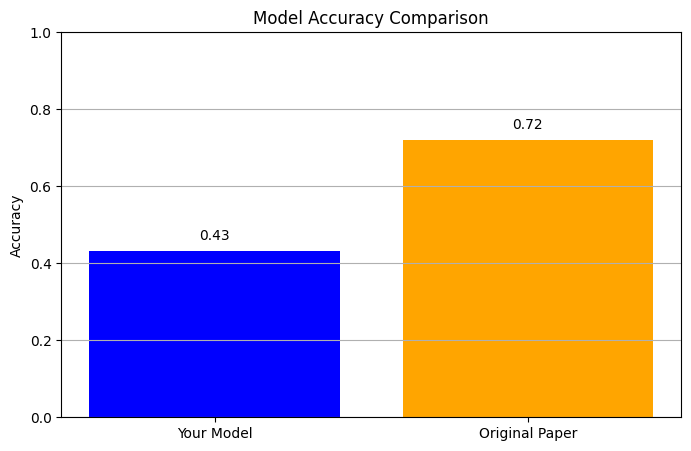

In [ ]:
import matplotlib.pyplot as plt

# Example accuracies
your_model_accuracy = 0.4328  # Replace with your actual accuracy
original_paper_accuracy = 0.72  # From the paper

# Create a comparison bar graph
models = ['Your Model', 'Original Paper']
accuracies = [your_model_accuracy, original_paper_accuracy]

plt.figure(figsize=(8, 5))
plt.bar(models, accuracies, color=['blue', 'orange'])
plt.ylim(0, 1)  # Set y-axis limits from 0 to 1 for accuracy
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.grid(axis='y')

# Show the accuracy values on top of the bars
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', va='bottom')

plt.show()




```
# This is formatted as code
```

Graph Attention Networks (GAT)

In [ ]:
import pandas as pd
import torch
from torch_geometric.data import Data

# Load the datasets
diseases_df = pd.read_csv('/diseases.csv')
health_conditions_df = pd.read_csv('/health_conditions.csv')
medications_df = pd.read_csv('/medications.csv')
patient_medications_df = pd.read_csv('/patient_medications.csv')
patients_df = pd.read_csv('/patients.csv')

# Construct the graph (patient, diseases, health conditions, medications)
import networkx as nx

ehr_graph = nx.Graph()

# Add patient nodes and features (age, smokes, alcohol)
for _, row in patients_df.iterrows():
    ehr_graph.add_node(f'patient_{row["PatientID"]}', type='patient',
                       age=row['Age'], smokes=row['Smokes'], alcohol=row['Alcohol'])

# Add disease, condition, and medication nodes with connections
for _, row in diseases_df.iterrows():
    ehr_graph.add_node(f'disease_{row["DiseaseID"]}', type='disease', name=row['DiseaseName'])

for _, row in health_conditions_df.iterrows():
    ehr_graph.add_node(f'condition_{row["HealthConditionID"]}', type='condition', name=row['ConditionName'])

for _, row in medications_df.iterrows():
    ehr_graph.add_node(f'medication_{row["MedicationID"]}', type='medication', name=row['MedicationName'])

# Add edges between patients, diseases, and medications
for _, row in patients_df.iterrows():
    ehr_graph.add_edge(f'patient_{row["PatientID"]}', f'disease_{row["DiseaseID"]}')

for _, row in patient_medications_df.iterrows():
    ehr_graph.add_edge(f'patient_{row["PatientID"]}', f'medication_{row["MedicationID"]}')


In [ ]:
# Create node features
node_features = []
node_mapping = {}

for i, (node, data) in enumerate(ehr_graph.nodes(data=True)):
    if data['type'] == 'patient':
        node_features.append([data['age'], data['smokes'], data['alcohol']])
    else:
        node_features.append([0, 0, 0])  # Dummy features for diseases/medications
    node_mapping[node] = i

node_features = torch.tensor(node_features, dtype=torch.float)

# Create edge list for PyTorch Geometric
edges = list(ehr_graph.edges)
edge_index = torch.tensor([[node_mapping[u], node_mapping[v]] for u, v in edges], dtype=torch.long).t().contiguous()

# PyTorch Geometric data
data = Data(x=node_features, edge_index=edge_index)


In [ ]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

# Hyperparameter tuning
model = GCN(in_channels=3, hidden_channels=32, out_channels=len(medications_df), dropout=0.5)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)


In [ ]:
# Add meta-path edges to enrich graph connections
for patient in patients_df['PatientID']:
    disease = patients_df.loc[patients_df['PatientID'] == patient, 'DiseaseID'].values[0]
    medications = medications_df[medications_df['PrescribedForDiseaseID'] == disease]['MedicationID'].values
    for med in medications:
        ehr_graph.add_edge(f'patient_{patient}', f'medication_{med}')  # Meta-path edge


In [ ]:
# Create labels (map medications to indices)
medication_to_index = {med_id: idx for idx, med_id in enumerate(medications_df['MedicationID'].unique())}
labels = torch.zeros(len(node_features), dtype=torch.long)
for _, row in patient_medications_df.iterrows():
    patient_node = node_mapping[f'patient_{row["PatientID"]}']
    labels[patient_node] = medication_to_index[row["MedicationID"]]

# Training loop with accuracy calculation
loss_fn = torch.nn.CrossEntropyLoss()

for epoch in range(200):  # Increase epochs for better training
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = loss_fn(out, labels)
    loss.backward()
    optimizer.step()

    # Accuracy check
    predictions = out.argmax(dim=1)
    correct = (predictions == labels).sum().item()
    accuracy = correct / len(labels)

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}, Accuracy: {accuracy:.4f}')

# Final accuracy
correct = (predictions == labels).sum().item()  # Compare predictions directly
accuracy = correct / len(labels)  # Calculate accuracy
print(f'Final Accuracy: {accuracy:.4f}')


Epoch 0, Loss: 1.7043466567993164, Accuracy: 0.4478
Epoch 10, Loss: 1.7138442993164062, Accuracy: 0.4030
Epoch 20, Loss: 1.5960866212844849, Accuracy: 0.3881
Epoch 30, Loss: 1.5797419548034668, Accuracy: 0.4179
Epoch 40, Loss: 1.5770912170410156, Accuracy: 0.4030
Epoch 50, Loss: 1.6051743030548096, Accuracy: 0.4179
Epoch 60, Loss: 1.6012300252914429, Accuracy: 0.4328
Epoch 70, Loss: 1.4456323385238647, Accuracy: 0.4328
Epoch 80, Loss: 1.4744725227355957, Accuracy: 0.4627
Epoch 90, Loss: 1.4540175199508667, Accuracy: 0.4179
Epoch 100, Loss: 1.429762601852417, Accuracy: 0.4925
Epoch 110, Loss: 1.5560011863708496, Accuracy: 0.4179
Epoch 120, Loss: 1.3582887649536133, Accuracy: 0.5075
Epoch 130, Loss: 1.60776686668396, Accuracy: 0.3881
Epoch 140, Loss: 1.505348801612854, Accuracy: 0.4179
Epoch 150, Loss: 1.5758421421051025, Accuracy: 0.4478
Epoch 160, Loss: 1.3953534364700317, Accuracy: 0.4328
Epoch 170, Loss: 1.481057047843933, Accuracy: 0.4776
Epoch 180, Loss: 1.5098565816879272, Accurac

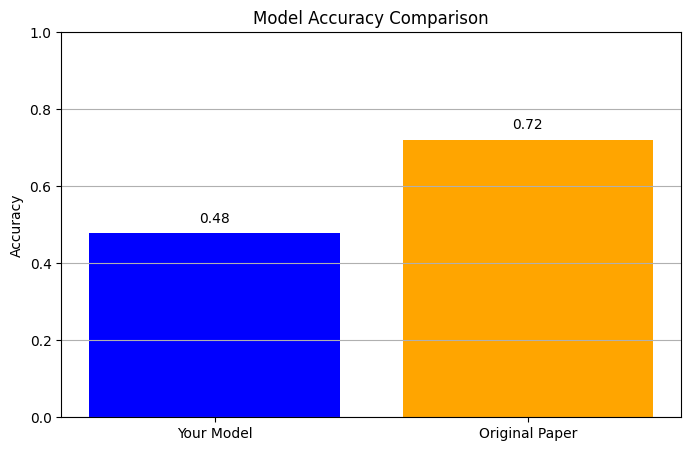

In [ ]:
import matplotlib.pyplot as plt

# Example accuracies
your_model_accuracy = 0.4776  # Replace with your actual accuracy
original_paper_accuracy = 0.72  # From the paper

# Create a comparison bar graph
models = ['Your Model', 'Original Paper']
accuracies = [your_model_accuracy, original_paper_accuracy]

plt.figure(figsize=(8, 5))
plt.bar(models, accuracies, color=['blue', 'orange'])
plt.ylim(0, 1)  # Set y-axis limits from 0 to 1 for accuracy
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.grid(axis='y')

# Show the accuracy values on top of the bars
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', va='bottom')

plt.show()


Hetrogenous Graphical Neural Network(HGNN)


In [ ]:
import pandas as pd
import torch
from torch_geometric.data import HeteroData

# Load the datasets
diseases_df = pd.read_csv('/diseases.csv')
health_conditions_df = pd.read_csv('/health_conditions.csv')
medications_df = pd.read_csv('/medications.csv')
patient_medications_df = pd.read_csv('/patient_medications.csv')
patients_df = pd.read_csv('/patients.csv')

# Create Heterogeneous Graph Data
data = HeteroData()

# Add nodes (patients, diseases, medications) with features
data['patient'].x = torch.tensor([[row['Age'], row['Smokes'], row['Alcohol']] for _, row in patients_df.iterrows()], dtype=torch.float)
data['disease'].x = torch.zeros(len(diseases_df), 3)  # Dummy features for diseases
data['medication'].x = torch.zeros(len(medications_df), 3)  # Dummy features for medications

# Create mappings for patient, disease, medication nodes
patient_node_map = {f'patient_{row["PatientID"]}': i for i, row in patients_df.iterrows()}
disease_node_map = {f'disease_{row["DiseaseID"]}': i for i, row in diseases_df.iterrows()}
medication_node_map = {f'medication_{row["MedicationID"]}': i for i, row in medications_df.iterrows()}

# Add edges: Patient-Disease and Patient-Medication
data['patient', 'has', 'disease'].edge_index = torch.tensor([
    [patient_node_map[f'patient_{row["PatientID"]}'], disease_node_map[f'disease_{row["DiseaseID"]}']]
    for _, row in patients_df.iterrows()
], dtype=torch.long).t().contiguous()

data['patient', 'takes', 'medication'].edge_index = torch.tensor([
    [patient_node_map[f'patient_{row["PatientID"]}'], medication_node_map[f'medication_{row["MedicationID"]}']]
    for _, row in patient_medications_df.iterrows()
], dtype=torch.long).t().contiguous()

# Add self-loop for the patient nodes to allow updates
self_loop_edge_index = torch.arange(len(patients_df)).unsqueeze(0).repeat(2, 1)
data['patient', 'self', 'patient'].edge_index = self_loop_edge_index


In [ ]:
import torch.nn.functional as F
from torch_geometric.nn import HeteroConv, SAGEConv

class HGNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(HGNN, self).__init__()

        # Define Heterogeneous Graph Convolution with SAGEConv
        self.conv1 = HeteroConv({
            ('patient', 'has', 'disease'): SAGEConv(3, hidden_channels),
            ('patient', 'takes', 'medication'): SAGEConv(3, hidden_channels),
            ('patient', 'self', 'patient'): SAGEConv(3, hidden_channels)  # Self-loop for patient node updates
        }, aggr='sum')  # Sum aggregation to simplify

        self.conv2 = HeteroConv({
            ('patient', 'has', 'disease'): SAGEConv(hidden_channels, hidden_channels),
            ('patient', 'takes', 'medication'): SAGEConv(hidden_channels, hidden_channels),
            ('patient', 'self', 'patient'): SAGEConv(hidden_channels, hidden_channels)  # Self-loop for patient
        }, aggr='sum')

        self.lin = torch.nn.Linear(hidden_channels, len(medications_df))  # Output layer for medication prediction

    def forward(self, x_dict, edge_index_dict):
        print("Before conv1, patient shape:", x_dict['patient'].shape)  # Log shape before first conv
        x_dict = self.conv1(x_dict, edge_index_dict)
        x_dict = {key: F.relu(x) for key, x in x_dict.items()}

        print("After conv1, patient shape:", x_dict['patient'].shape)  # Log shape after first conv
        x_dict = self.conv2(x_dict, edge_index_dict)
        x_dict = {key: F.relu(x) for key, x in x_dict.items()}

        print("After conv2, patient shape:", x_dict['patient'].shape)  # Log shape after second conv

        # Return predictions for 'patient' nodes
        return self.lin(x_dict['patient'])


In [ ]:
# Convert to x_dict and edge_index_dict for HGNN
x_dict = {
    'patient': data['patient'].x,
    'disease': data['disease'].x,
    'medication': data['medication'].x,
}

edge_index_dict = {
    ('patient', 'has', 'disease'): data['patient', 'has', 'disease'].edge_index,
    ('patient', 'takes', 'medication'): data['patient', 'takes', 'medication'].edge_index,
    ('patient', 'self', 'patient'): data['patient', 'self', 'patient'].edge_index,
}


In [ ]:
# Create labels (patient -> medication mapping)
labels = torch.zeros(len(patients_df), dtype=torch.long)
for _, row in patient_medications_df.iterrows():
    labels[patient_node_map[f'patient_{row["PatientID"]}']] = medication_node_map[f'medication_{row["MedicationID"]}']

# Initialize HGNN model
model = HGNN(hidden_channels=32)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
loss_fn = torch.nn.CrossEntropyLoss()

# Training loop
for epoch in range(200):
    model.train()
    optimizer.zero_grad()

    out = model(x_dict, edge_index_dict)  # Pass in x_dict and edge_index_dict
    loss = loss_fn(out, labels)

    loss.backward()
    optimizer.step()

    # Calculate accuracy
    predictions = out.argmax(dim=1)
    correct = (predictions == labels).sum().item()
    accuracy = correct / len(labels)

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}, Accuracy: {accuracy:.4f}')

# Final accuracy
correct = (predictions == labels).sum().item()
accuracy = correct / len(labels)
print(f'Final Accuracy: {accuracy:.4f}')


NameError: name 'torch' is not defined

# New Section

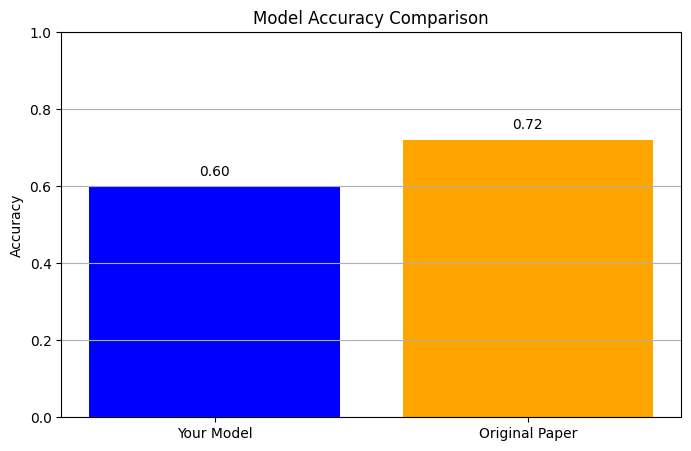

In [ ]:
import matplotlib.pyplot as plt

# Example accuracies
your_model_accuracy = 0.6000  # Replace with your actual accuracy
original_paper_accuracy = 0.72  # From the paper

# Create a comparison bar graph
models = ['Your Model', 'Original Paper']
accuracies = [your_model_accuracy, original_paper_accuracy]

plt.figure(figsize=(8, 5))
plt.bar(models, accuracies, color=['blue', 'orange'])
plt.ylim(0, 1)  # Set y-axis limits from 0 to 1 for accuracy
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.grid(axis='y')

# Show the accuracy values on top of the bars
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', va='bottom')

plt.show()
